In [1]:
import torch
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from models.depth_model import StereoDepthNet as DepthNetwork

In [2]:
import argparse
args = argparse.ArgumentParser()

args.image_height = 192
args.image_width = 320
args.working_resolution = (args.image_width, args.image_height)
args.use_gt_poses = False
args.use_gray_scale = False
args.use_stereo = True
args.seq_length = 1
args.stride = 1
args.use_multi_scale_images = False
args.undistort = False
args.use_full_res = False
args.use_seq = False
args.use_pose = False
args.batch_size = 1
args.split = "train"
args.learning_rate = 1e-4
args.dataset = "robotcar"
from datasets.robotcar.day_night_paried_dataset import (
    DayNightDataset as RobotCarDataset,
)
args.data_path = "/hdd1/madhu/data/robotcar"  # /2014-12-16-18-44-24/stereo/"
dataset = RobotCarDataset(args)
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=8,
        pin_memory=True,
        sampler=None,
    )


In [3]:
depth_net = DepthNetwork(args, reg_refine=False)
depth_net.cuda()
depth_net.eval()

Using cache found in /home/madhu/.cache/torch/hub/facebookresearch_dino_main


StereoDepthNet(
  (model): UniMatch(
    (projector): Sequential(
      (0): Conv2d(384, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (transformer): FeatureTransformer(
      (layers): ModuleList(
        (0-5): 6 x TransformerBlock(
          (self_attn): TransformerLayer(
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (merge): Linear(in_features=128, out_features=128, bias=False)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (cross_attn_ffn): TransformerLayer(
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_feature

In [13]:
def extract_features_dino_v1(image0, image1):

    dino_patch_size = 8
    dino_stride = 4
    dino_layers = [5,11]

    image_shape = image0.shape[2:]
    fine_height = 1 + (image_shape[0] - dino_patch_size) // dino_stride
    fine_width = 1 + (image_shape[1] - dino_patch_size) // dino_stride

    coarse_height = image_shape[0] // dino_patch_size
    coarse_width = image_shape[1] //dino_patch_size


    #print(coarse_height, coarse_width, fine_height, fine_width)


    with torch.no_grad():
    #with torch.autocast(device_type='cuda', dtype=torch.float16):
        desc0 = depth_net.dino._extract_features(
            image0, layers=dino_layers, facet="token"
        )
        desc1 = depth_net.dino._extract_features(
            image1, layers=dino_layers, facet="token"
        )

        #print(desc0[-1].shape, desc1[-1].shape)
        #print(desc0[0].shape, desc1[0].shape)

        coarse_feat0 = desc0[-1][:, 1:, :].permute(0, 2, 1)
        coarse_feat1 = desc1[-1][:, 1:, :].permute(0, 2, 1)

        fine_feat0 = desc0[0][:, 1:, :].permute(0, 2, 1)
        fine_feat1 = desc1[0][:, 1:, :].permute(0, 2, 1)

        batch_size = desc0[0].shape[0]
        coarse_feat0 = coarse_feat0.view(
            batch_size, -1, coarse_height, coarse_width
        )
        coarse_feat1 = coarse_feat1.contiguous().view(
            batch_size, -1, coarse_height, coarse_width
        )

        fine_feat0 = fine_feat0.contiguous().view(
            batch_size, -1, fine_height, fine_width
        )
        fine_feat1 = fine_feat1.contiguous().view(
            batch_size, -1, fine_height, fine_width
        )

        fine_feat0 = torch.nn.functional.pad(fine_feat0, (0, 1, 0, 1))
        fine_feat1 = torch.nn.functional.pad(fine_feat1, (0, 1, 0, 1))

    return [coarse_feat0, fine_feat0], [coarse_feat1, fine_feat1]

In [ ]:
#for data in dataloader:break

In [ ]:
# night_frame = data['frame0']
# day_frame = data['frame1']

# n_left = night_frame['image'].cuda()
# n_right = night_frame['stereo_pair'].cuda()

# d_left = day_frame['image'].cuda()
# d_right = day_frame['stereo_pair'].cuda()

In [ ]:
def imshow(image:torch.tensor):
    np_image = image.squeeze().cpu().numpy()
    np_image = np.transpose(np_image, (1,2,0))
    plt.imshow(np_image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [18]:
import cv2
night_img_path = '/home/madhu/code/feature-slam/git_repos/dtd/img0.png'
day_img_path = '/home/madhu/code/feature-slam/git_repos/dtd/img1.png'

img0 = cv2.imread(night_img_path)
img1 = cv2.imread(day_img_path)
img0 = cv2.resize(img0, (320,192))
img1 = cv2.resize(img1, (320,192))

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

np_img0 = img0/255.
np_img1 = img1/255.

torch_img0 = torch.from_numpy(img0).unsqueeze(0).cuda().permute(0,3,1,2)
torch_img1 = torch.from_numpy(img1).unsqueeze(0).cuda().permute(0,3,1,2)



In [19]:
feat0,feat1 = extract_features_dino_v1(torch_img0.float(),torch_img1.float())

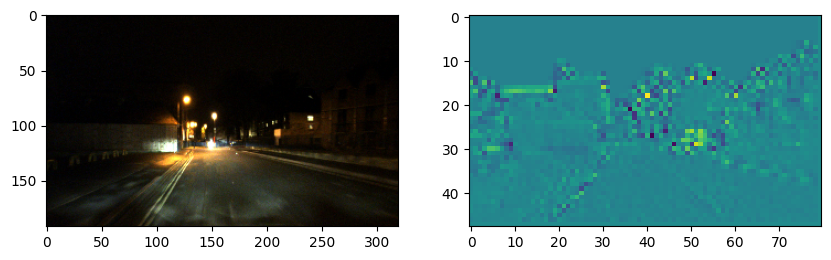

In [33]:
np_feat = feat1[1][0][0].detach().cpu().numpy()
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(np_img0)
ax[1].imshow(np_feat)

In [ ]:
#need to pca these and get the top 3 features

night_feat, day_feat = left_features

night_corse_feat = night_feat[0].flatten(2).permute(0,2,1).squeeze()
day_corse_feat = day_feat[0].flatten(2).permute(0,2,1).squeeze()

night_corse_feat = night_corse_feat.cpu().numpy()
day_corse_feat = day_corse_feat.cpu().numpy()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
night_corse_feat = pca.fit_transform(night_corse_feat)
day_corse_feat = pca.fit_transform(day_corse_feat)




In [ ]:
night_feat = night_corse_feat.transpose(1,0).reshape(2,24,40)
day_feat = day_corse_feat.transpose(1,0).reshape(2,24,40)

fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(night_feat[0])
ax[0,1].imshow(day_feat[0])
ax[1,0].imshow(night_feat[1])
ax[1,1].imshow(day_feat[1])


plt.tight_layout()
plt.show()

In [ ]:
def featshow(feature:torch.tensor):
    np_feat = feature.squeeze().detach().cpu().numpy()
    plt.imshow(np_feat[2], cmap='plasma')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    

In [ ]:
featshow(left_features[0][0])
imshow(n_left[0])
featshow(left_features[1][0])
imshow(d_left[0])

In [ ]:
checkpoint_path = "/mnt/nas/madhu/data/checkpoints/chapter_4_cvpr/dino_v1_d_n_2/depth_net_10.pth"
depth_net.load_state_dict(torch.load(checkpoint_path), strict=False)

In [ ]:
night_feat = left_features[0]
day_feat = left_features[1]

proj_night_coarse_feat = depth_net.model.projector(night_feat[0])
proj_day_coarse_feat = depth_net.model.projector(day_feat[0])


In [ ]:
proj_day_coarse_feat.shape

featshow(proj_night_coarse_feat)
featshow(proj_day_coarse_feat)